In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest, uncertainty_subtraction as us, calculate as calc

from astropy.table import hstack
import numpy as np
import matplotlib.pyplot as plt

#collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs([], [], "../data_processed/toy_model/toy_hvcs/", toy_override=True)

bigger_results = ct.read_processed("../data_processed/toy_model/results_final_unfiltered")
#big_results_filtered = ct.read_processed("../data_processed/toy_model/results_final_filtered")
bigger_results

=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM,Average [inner],Average [outer],Average [diff],Avg Unc [inner],Avg Unc [outer],Avg Unc [diff],KS unc
str67,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
toy_0_0.0_0.0_0.0.ecsv,0.15512615945713734,0.02416490935579006,0.546875,-1,-0.0036755505505539077,False,0.7181247448032667,0.43199068054162376,nan,nan,nan,0.13206216582583086,0.06187903704760876,0.0701831287782221,0.0019822617659745454,0.0001830740741053514,0.001990697823742734,0.8910528192480175
toy_0_0.0_0.0_0.7853981633974483.ecsv,0.15512615945713734,0.02416490935579006,0.546875,-1,-0.0036755505505539077,False,0.6504944929722889,0.2787985633411827,nan,nan,nan,0.1413938042103961,0.06187903704760876,0.07951476716278734,0.00205210872803258,0.0001830740741053514,0.0020602588061399045,0.8375052614630897
toy_0_0.0_0.0_1.5707963267948966.ecsv,0.12254738650909154,0.1250838416045315,0.109375,-1,0.059324949949946415,False,0.5521426408126524,0.20198135638324727,nan,nan,nan,0.09215149775079459,0.06187903704760876,0.03027246070318583,0.0011376728117382048,0.0001830740741053514,0.0011523087881196794,0.7636317655746471
toy_0_0.0_0.0_2.356194490192345.ecsv,0.0917395802282969,0.4127193027413549,0.3203125,1,-0.13013795045045384,False,0.6252851582222411,0.2553787524570038,nan,nan,nan,0.13185791111151304,0.06187903704760876,0.06997887406390428,0.0020832703328715514,0.0001830740741053514,0.002091298973468948,0.8180791567349067
toy_0_0.0_0.0_3.141592653589793.ecsv,0.10641580894601183,0.2439601275322874,-0.2327370731741204,1,-0.18268702312407392,False,0.6982127086292612,0.4046139519692637,nan,nan,nan,0.1266502050670992,0.06187903704760876,0.06477116801949044,0.002114574047548032,0.0001830740741053514,0.0021224842800768155,0.875084546819616
toy_0_0.0_0.0_3.9269908169872414.ecsv,0.11772544756360576,0.15422986809584666,0.36328125,1,-0.08716920045045384,False,0.6257551735065523,0.2577992608363467,nan,nan,nan,0.1321422854170526,0.06187903704760876,0.07026324836944385,0.0020904068600567567,0.0001830740741053514,0.002098408196033813,0.8184384611938141
toy_0_0.0_0.0_4.71238898038469.ecsv,0.12254738650909154,0.1250838416045315,0.109375,-1,0.059324949949946415,False,0.5521426408126525,0.20198135638324727,nan,nan,nan,0.09215149775079559,0.06187903704760876,0.03027246070318683,0.0011376728117382176,0.0001830740741053514,0.001152308788119692,0.7636317655746472
toy_0_0.0_0.0_5.497787143782138.ecsv,0.1644719538496607,0.014050395172507146,0.546875,-1,-0.0036755505505539077,False,0.6515736544152392,0.2760786238074689,nan,nan,nan,0.1426047883545859,0.06187903704760876,0.08072575130697714,0.0020562409259283283,0.0001830740741053514,0.002064374690329283,0.838343727070891
toy_0_0.0_0.7853981633974483_0.0.ecsv,0.12708877627956724,0.10164890612991566,0.546875,-1,-0.0036755505505539077,False,0.6765737106913561,0.35500403496551103,nan,nan,nan,0.14009990953013815,0.06187903704760876,0.07822087248252939,0.0021563223549002325,0.0001830740741053514,0.0021640799927109943,0.8579183898190748


In [2]:
from astropy.table import Table

def post_process_magnetic_fields(master_hvcs, data):
    name_list = []
    sign_list = []
    uner_list = []

    ksl_list = []
    uns_list = []
    wgm_list = []

    ksl_unc_list = []
    uns_unc_list = []
    wgm_unc_list = []

    for i in range(len(master_hvcs)):
        name_list.append(master_hvcs[i]["HVC"]["Name"])
        sign_list.append(data[i]["Significant"])
        uner_list.append(data[i]["Sigma [diff]"])

        #val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Statistic_diff"], data[i]["KS unc"])[0]
        ksl_list.append( data[i]["Statistic_diff"])
        ksl_unc_list.append(data[i]["KS unc"])

        #val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Sigma [diff]"], data[i]["Sigma unc"])[0]
        uns_list.append(data[i]["Sigma [diff]"])
        uns_unc_list.append(1)#data[i]["Sigma unc"])

        #val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Average [diff]"], data[i]["Avg Unc [diff]"])[0]
        wgm_list.append(data[i]["Average [diff]"])
        wgm_unc_list.append(data[i]["Avg Unc [diff]"])
    
    t = Table()
    t.add_columns([name_list, sign_list, uner_list, ksl_list, ksl_unc_list, uns_list, uns_unc_list, wgm_list, wgm_unc_list], names=["Name", "Significant", "Sigma [diff]", "KS-EDF", "KS-EDF Unc", "Var. Sub.", "Var. Sub. Unc", "Wgt. Mean", "Wgt. Mean Unc"])
    return t

finals = post_process_magnetic_fields(master_hvcs, bigger_results)
filtered = us.filter_significant(finals, sigma_filter=False)


In [3]:
results = ct.write_processed(filtered, "../data_processed/toy_model/results_post")

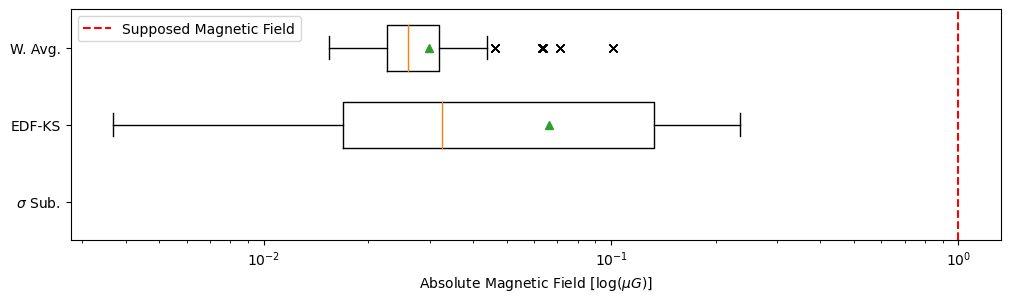

In [5]:
dic = {r"$\sigma$ Sub.": abs(filtered["Var. Sub."]), "EDF-KS": abs(filtered["KS-EDF"]), "W. Avg.": abs(filtered["Wgt. Mean"])}
plt.figure(figsize=(12,3))
plt.boxplot(dic.values(), labels=dic.keys(), vert=False, showmeans=True, widths=0.6, sym="x")
plt.axvline(1, c='r', linestyle='--', label=r"Supposed Magnetic Field")
plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.xscale('log')
#plt.xlim(0.1, 15)
plt.legend()
plt.show()

In [8]:
print(100*len(filtered)/len(finals))
print(len(filtered))

12.630208333333334
388


In [6]:
from scipy.stats import linregress

results_stack = us.filter_significant(hstack([finals, collated_data['HVCs']]))

Var. Sub. slope: -12.572703226550608
KS-EDF slope:    -26.856579544439352
Wgt. Avg. slope: -3.8528375397646086
Var. Sub. x-int: 1.6735447035564783
KS-EDF x-int:    1.5285419214826035
Wgt. Avg. x-int: 4.336392407460455
Var. Sub. R^2:   0.059632232139626914
KS-EDF R^2:      0.05764859225859303
Wgt. Avg. R^2:   0.007095225964694864


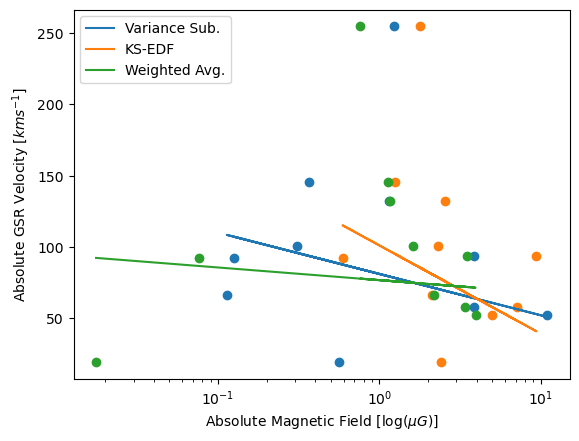

In [7]:
plt.scatter(abs(results_stack["Var. Sub."]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["KS-EDF"]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["Wgt. Mean"]), abs(results_stack['VGSR']))

plt.xscale('log')
#plt.xlim(0.1, 15)

pf10, pf11, r_value1, p_value1, std_err1 = linregress(np.log(abs(results_stack["Var. Sub."])), abs(results_stack['VGSR']))
pf20, pf21, r_value2, p_value2, std_err2 = linregress(np.log(abs(results_stack["KS-EDF"])), abs(results_stack['VGSR']))
pf30, pf31, r_value3, p_value3, std_err3 = linregress(np.log(abs(results_stack["Wgt. Mean"])), abs(results_stack['VGSR']))

plt.plot(abs(results_stack["Var. Sub."]), pf10 * np.log(abs(results_stack["Var. Sub."])) + pf11, label="Variance Sub.")
plt.plot(abs(results_stack["KS-EDF"]), pf20 * np.log(abs(results_stack["KS-EDF"])) + pf21, label="KS-EDF")
plt.plot(abs(results_stack["Wgt. Mean"]), pf30 * np.log(abs(results_stack["Wgt. Mean"])) + pf31, label="Weighted Avg.")

plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.ylabel(r"Absolute GSR Velocity [$km s^{-1}$]")
plt.legend()

print(r"Var. Sub. slope: "+str(pf10))
print(r"KS-EDF slope:    "+str(pf20))
print(r"Wgt. Avg. slope: "+str(pf30))

#print(r"Var. Sub. y-int: "+str(pf11))
#print(r"KS-EDF y-int:    "+str(pf21))

print(r"Var. Sub. x-int: "+str((60-pf11)/pf10))
print(r"KS-EDF x-int:    "+str((60-pf21)/pf20))
print(r"Wgt. Avg. x-int: "+str((60-pf31)/pf30))

print(r"Var. Sub. R^2:   "+str(r_value1**2))
print(r"KS-EDF R^2:      "+str(r_value2**2))
print(r"Wgt. Avg. R^2:   "+str(r_value3**2))

plt.show()

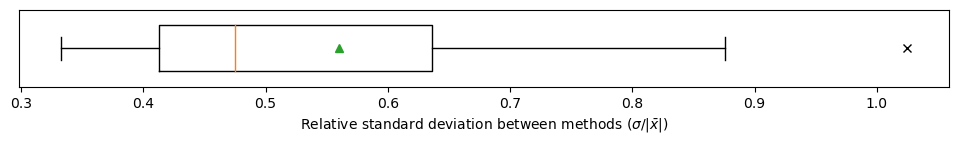

In [8]:
plt.figure(figsize=(12,1))

lists = [abs(big_results_filtered["Sigma [diff]"]), abs(big_results_filtered["Statistic_diff"]), abs(big_results_filtered["Average [diff]"])]

std = np.std(lists, axis=0)/np.mean(lists, axis=0)

plt.boxplot(std, vert=False, showmeans=True,widths=0.6, sym="x")
plt.yticks([])
#plt.axvline(8, c='r', linestyle='--', label=r"Smith Cloud")
plt.xlabel(r"Relative standard deviation between methods ($\sigma/|\bar{x}|$)")
#plt.xscale('log')
#plt.xlim(0.1, 15)
#plt.legend()
plt.show()